# CLIO SkySubtraction
       Written by Logan A. Pearce, 2019


Based on the math described in Soummer+ 2012 Section 2 (https://arxiv.org/pdf/1207.4197.pdf), this script uses Principle Component Analysis to model and subtract the sky background of images from MagAO CLIO camera on Clay Telescope at Magellan.  The user supplies the path to a folder of fits images to use to build the sky modes and then to subtract.  Fits files can be coadded (2-dimensional) or a stack of coadds (3-dimensional, each coadd will be individually sky subtracted).  The user can specify the number of KLIP modes to use in building the model (default = 5), and if you would like bad pixels to be replaced or not (default = True).  
The script then:<br>
- Builds a stack of reference images by sorting fits files into Nod 0 or Nod 1 using the "BEAM" keyword header.  **Note - this assumes the header keyword is correct. It may not be so examine your files if things look weird.
- Builds a basis set of eigenimages (Z in Soummer, 2.2.2) from the reference stack for each Nod
- Opens each image in the dataset individually and for each image:
    - determines the Nod of the image and grabs the basis set for the opposite Nod (otherwise self subtraction)
    - projects the science image onto the basis set (Soummer 2.2.4)
    - subtracts the projected sky from the science image
    - replaces bad pixels with a value of 0 (more below)
    - ammends the header with the date and time or sky subtraction
    - ammends the filename to add appendix _skysub.fits to image filename
    - writes the subtracted file to fits in the same directory as the input image.

If the number of reference images is less than the user specified KLIP modes, the script will adjust the KLIP modes to the minimum number of reference images.
 
If badpixelreplace = True, the script will look for the bad pixel maps supplied by the MagAO team (and included in this GitHub repo).  If the script doesn't find the bad pixel maps, it will retrieve them directly from the MagAO wiki.

<br>
Sometimes instead of opposite nods, the observer will have used only one nod and taken sub skyframes (with filename appendix sky_).  In that case use <b>pcaskysub.clio_skysubtract_wskyframes</b> which functions the exact same way but builds the sky model from the sky frames rather than opposite nods.

Dependencies: numpy, astropy

In [2]:
from cliotools.pcaskysub import clio_skysubtract
help(clio_skysubtract)

Help on function clio_skysubtract in module cliotools.pcaskysub:

clio_skysubtract(path, K_klip=5, skip_list=False, write_file=True, badpixelreplace=True)
    Skysubtract an entire dataset
    Parameters:
    -----------
    path : str
        path to science images including image prefixes and underscores.  
        ex: An image set of target BDI0933 with filenames of the form BDI0933__00xxx.fit
            would take as input a path string of 'BDI0933/BDI0933__'
    K_klip : int
        Number of basis modes to use in subtraction 
    skip_list : bool
        Set to True if a list of paths to science files has already been made.  List
        must be named "list"
    write_file : bool
        Set to False to skip writing the sky subtracted file to disk.  
    badpixelreplace : bool
        Set to False to skip replacing bad pixels
        
    Returns:
    --------
    If write_file = True, writes skysubtracted images to file with filename appended with 'skysub'
    ex: skysubtracted

In [5]:
import numpy as np
# Specify path to dataset:
path = 'example_data/BD03884A_'
K_klip = 10
# In the example dataset, there are only 3 images in Nod 1, so exepct the script to update and tell you it 
# is using K_klip = 3 instead of 10.

clio_skysubtract(path, K_klip=K_klip, skip_list = False)

Stacking reference images for example_data ...
I will use  12  images for Nod 0, and  3 images for Nod 1
Oops, there are fewer images than your requested number of modes.  Using all the images              in the reference set
K_klip = 3
Building eigenimages...
Building eigenimages...
Subtracting...
100% (15 of 15): |####################|  Done...
Done.


## Checking your work:

<IPython.core.display.Javascript object>


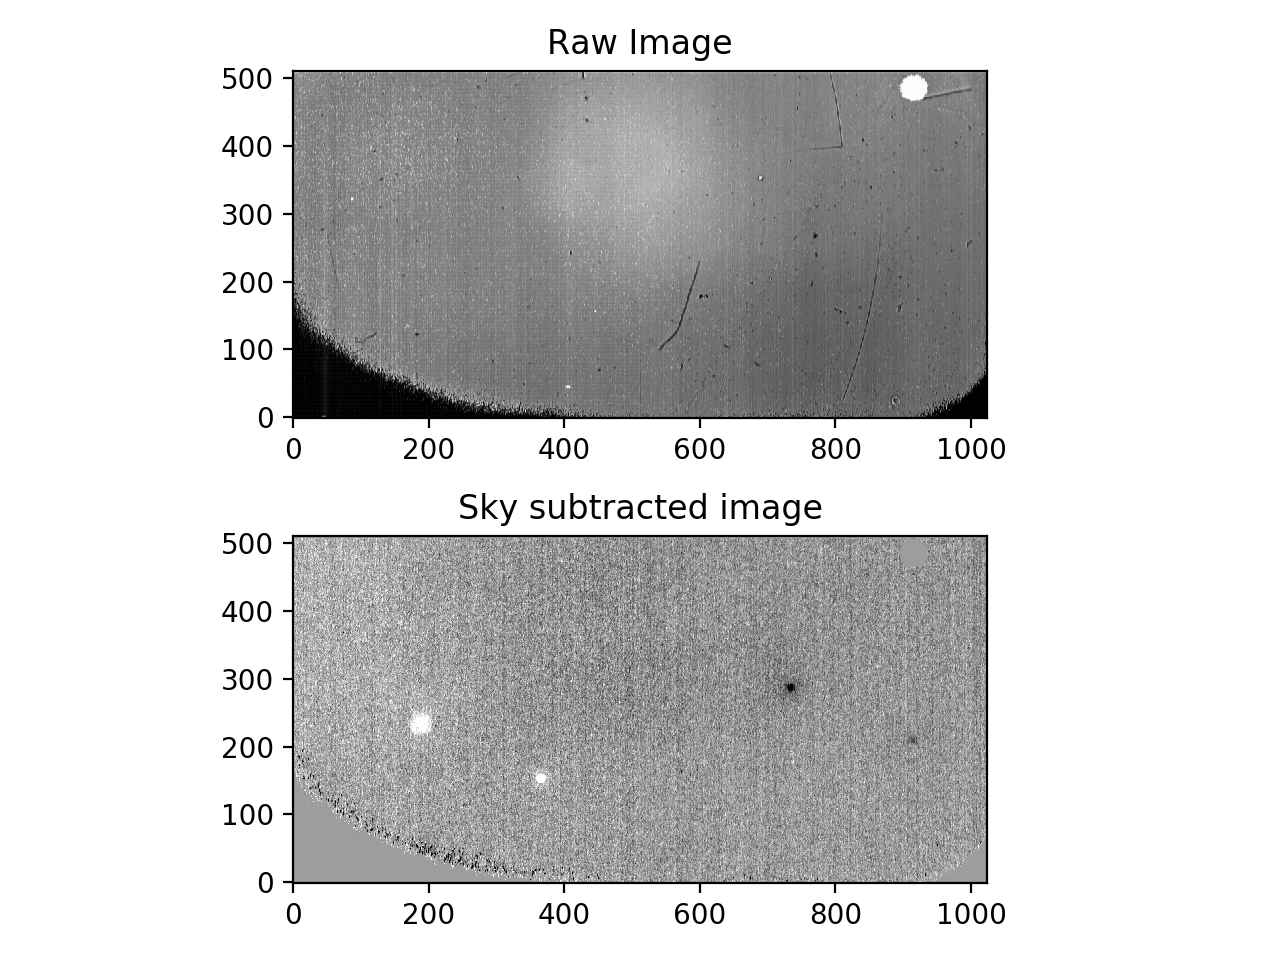

In [7]:
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.io import fits
raw = fits.getdata('example_data/BD03884A_00001.fit')
skysub = fits.getdata('example_data/BD03884A_00001_skysub.fit')
%matplotlib notebook
plt.subplot(211)
plt.imshow(raw, origin='lower',cmap='gray',norm = ImageNormalize(raw, interval=ZScaleInterval(),))
plt.title('Raw Image')
plt.subplot(212)
plt.imshow(skysub, origin='lower',cmap='gray',norm = ImageNormalize(skysub, interval=ZScaleInterval(),))
plt.title('Sky subtracted image')
plt.tight_layout()
plt.show()

The two dark areas in the sky subtracted image are the locations of the two stars in the opposite Nod, so they are positive locations in the sky estimator, which become negative when subtracted from the science image.